In [1]:
import networkx as nx
import numpy as np
from tqdm import tqdm
import torch
from src.mixturemodel import MixtureModel
from src.sbm import generate_sbm, MySbmFromScratch
from src.utils import random_permute_adj
import torch.multiprocessing as mp
import matplotlib.pyplot as plt

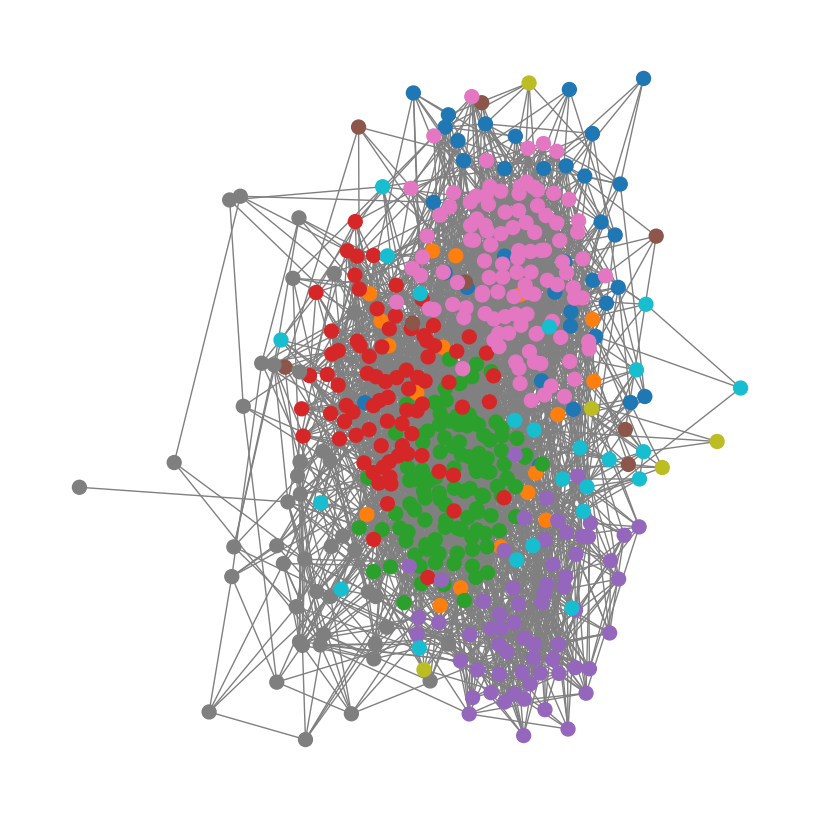

In [14]:
n=500
k=10

sbm = MySbmFromScratch()

sbm.generate_graph(N=n, K=k, _lambda=0.1, multiplier=1.3, alpha=1)
sbm.plot_graph()
model = MixtureModel(sbm.adj, sbm.adj.shape[0], k, device="cuda")

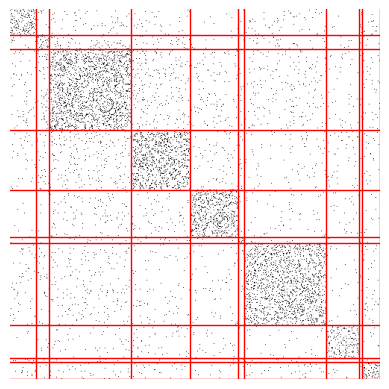

In [15]:
sbm.plot_adj()

100%|██████████| 20/20 [01:43<00:00,  5.19s/it]


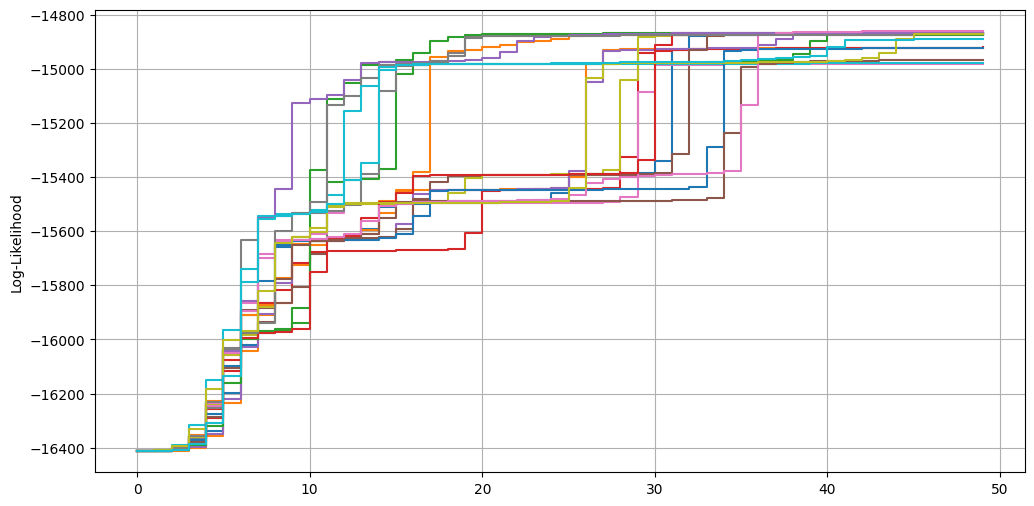

In [16]:
mp.set_start_method('spawn', force=True)

model = MixtureModel(sbm.adj, sbm.adj.shape[0], k, device='cuda')
resultats = model.em_parallelised_2( return_params=True, init="", max_it=50, tolerance=1e-4, num_inits=20)
model.plot_logs_path()
# init = "" signifie une initialisation aléatoire pour tau

100%|██████████| 20/20 [02:10<00:00,  6.53s/it]


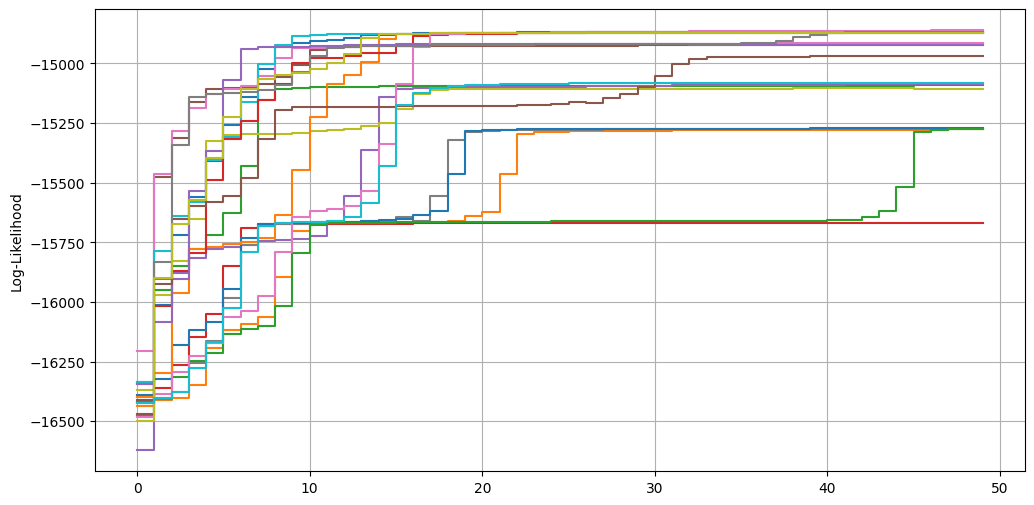

In [17]:
mp.set_start_method('spawn', force=True)

model = MixtureModel(sbm.adj, sbm.adj.shape[0], k, device='cuda') # K = 5
resultats = model.em_parallelised_2( return_params=True, init="Kmeans", max_it=50, tolerance=1e-4, num_inits=20)
model.plot_logs_path()

In [ ]:
list_inits = ["Random", "Sparse", "Kmeans"]
list_Q = [3, 20]
list_n = [100, 1000]
all_res = {}

for init in list_inits:
    all_res[init] = {}

for Q in list_Q:
    for n in list_n:
        sbm = MySbmFromScratch()

        sbm.generate_graph(N=n, K=Q, _lambda=0.1, multiplier=1.3, alpha=1.5)

        for init in tqdm(list_inits, desc=f'computing for n = {n} & Q = {Q}'):
            mp.set_start_method('spawn', force=True)
            model = MixtureModel(sbm.adj, sbm.adj.shape[0], Q, device='cuda')
            resultats = model.em_parallelised_2( return_params=True, init=init, max_it=50, tolerance=1e-4, num_inits=5,
                                                verbose=False)
            all_res[init][f"{n},{Q}"] = model.all_res
            all_res[init][f"like {n},{Q}"] = resultats["likelihood"]


In [3]:
for key in all_res["Random"].keys():
    if key[:4] == "like":
        print(f"Likelihood with parameters {key} & random inits :", round(all_res["Random"][key],2))

Likelihood with parameters like 100,3 & random inits : -2696.67
Likelihood with parameters like 1000,3 & random inits : -136384.72
Likelihood with parameters like 100,20 & random inits : -164.64
Likelihood with parameters like 1000,20 & random inits : -26474.21


In [4]:
for key in all_res["Sparse"].keys():
    if key[:4] == "like":
        print(f"Likelihood with parameters {key} & random inits :", round(all_res["Sparse"][key],2))

Likelihood with parameters like 100,3 & random inits : -2696.65
Likelihood with parameters like 1000,3 & random inits : -136384.72
Likelihood with parameters like 100,20 & random inits : -167.94
Likelihood with parameters like 1000,20 & random inits : -26430.59


In [5]:
for key in all_res["Kmeans"].keys():
    if key[:4] == "like":
        print(f"Likelihood with parameters {key[5:]} & random inits :", round(all_res["Kmeans"][key],2))

Likelihood with parameters 100,3 & random inits : -2696.57
Likelihood with parameters 1000,3 & random inits : -136384.72
Likelihood with parameters 100,20 & random inits : -179.41
Likelihood with parameters 1000,20 & random inits : -26279.75


In [ ]:
model = MixtureModel(sbm.adj, sbm.adj.shape[0], Q, device='cuda')
resultats = model.em_parallelised_2( return_params=True, init=init, max_it=50, tolerance=1e-4, num_inits=20,
                                    verbose=True)

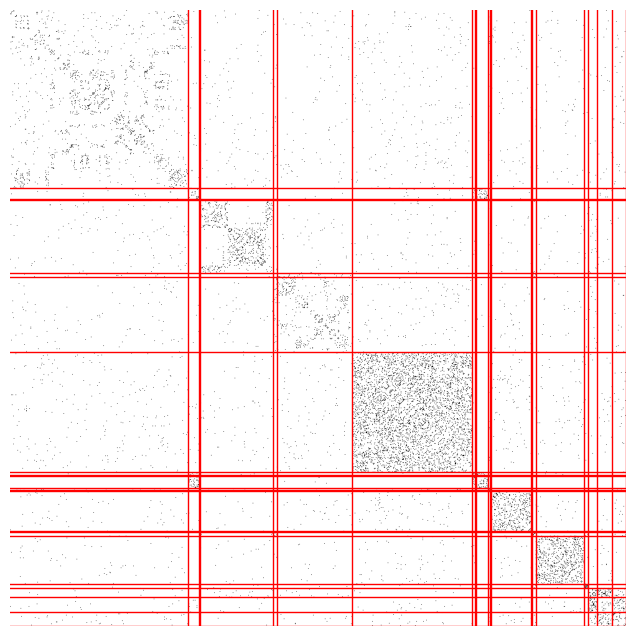

In [11]:
model.plot_preds_adjancy(resultats["tau"])

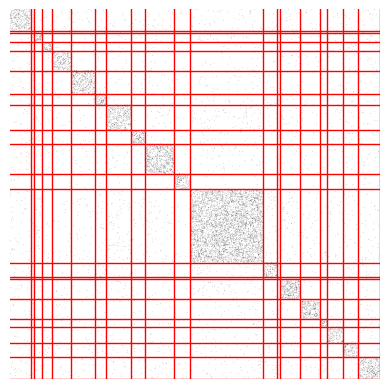

In [12]:
sbm.plot_adj()

In [16]:
from src.metrics import comp_nmi

In [17]:
comp_nmi(sbm.G, resultats["tau"])

0.7445882761717699